# **Lets install PySpark.**

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar xf spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [3]:
!pwd

/content


#Import Data

In [4]:
 from google.colab import drive
drive.mount('googledrive')

Mounted at googledrive


In [5]:
mobility_data = spark.read.csv("googledrive/MyDrive/csc8002 final_project/data.csv", header=True, inferSchema=True)

In [6]:
cc_data = spark.read.csv("googledrive/MyDrive/csc8002 final_project/covid_cases.csv", header=True, inferSchema=True)

In [7]:
mobility_data.show()

+-------------------+--------------------+------------+------------+----------+---------------+----------------+----------+--------------------------------------------------+-------------------------------------------------+----------------------------------+---------------------------------------------+---------------------------------------+----------------------------------------+
|country_region_code|      country_region|sub_region_1|sub_region_2|metro_area|iso_3166_2_code|census_fips_code|      date|retail_and_recreation_percent_change_from_baseline|grocery_and_pharmacy_percent_change_from_baseline|parks_percent_change_from_baseline|transit_stations_percent_change_from_baseline|workplaces_percent_change_from_baseline|residential_percent_change_from_baseline|
+-------------------+--------------------+------------+------------+----------+---------------+----------------+----------+--------------------------------------------------+-------------------------------------------------+--

In [8]:
cc_data.show()

+--------+---------+-----------+----------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+-------------------------------------+----------------+-----------+------------------+----------+-------------+-------------+--------------+--

# Exploratory Analysis

In [9]:
from pyspark.sql.functions import  *
from pyspark.sql import DataFrame
from typing import Iterable
import pandas as pd
import numpy as np
from google.colab import files

sum_null_df = cc_data.select([count(when(isnull(c), c)).alias(c) for c in cc_data.columns])
sum_null_df.toPandas().to_csv('googledrive/MyDrive/csc8002 final_project/nulls_col.csv')

Filter data sets just for Australia and South Korea

In [10]:
mobility_data.createTempView("temp_mob")
cc_data.createTempView("temp_cases")


In [11]:
mobility_aus_sk = spark.sql("""
SELECT country_region, date, retail_and_recreation_percent_change_from_baseline, 
grocery_and_pharmacy_percent_change_from_baseline, parks_percent_change_from_baseline,
transit_stations_percent_change_from_baseline, workplaces_percent_change_from_baseline,
residential_percent_change_from_baseline
FROM temp_mob
""").where("(country_region == 'Australia' AND sub_region_1 IS NULL) OR (country_region == 'South Korea' AND sub_region_1 IS NULL)")#.\
#orderBy(col("date").desc(),col("sub_region_1").desc()).show()

In [12]:
cases_aus_sk = spark.sql("""
SELECT * 
FROM temp_cases
""").where("location == 'Australia' OR location = 'South Korea'")
cases_aus_sk = cases_aus_sk.na.fill(value=0)


In [13]:
cases_aus_sk.show()

+--------+---------+---------+----------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+-------------------------------------+----------------+-----------+------------------+----------+-------------+-------------+--------------+----

In [14]:
from pyspark.sql import functions as F

df = mobility_aus_sk.join(cases_aus_sk, 
                          (mobility_aus_sk.country_region == cases_aus_sk.location) & 
                                 (mobility_aus_sk.date == cases_aus_sk.date), 
                          "inner").drop(cases_aus_sk.date) 
df = df.withColumn(
            'date',
                F.to_date(
                    F.unix_timestamp('date', 'yyyy-MM-dd').cast('timestamp')))
df.schema


StructType(List(StructField(country_region,StringType,true),StructField(date,DateType,true),StructField(retail_and_recreation_percent_change_from_baseline,IntegerType,true),StructField(grocery_and_pharmacy_percent_change_from_baseline,IntegerType,true),StructField(parks_percent_change_from_baseline,IntegerType,true),StructField(transit_stations_percent_change_from_baseline,IntegerType,true),StructField(workplaces_percent_change_from_baseline,IntegerType,true),StructField(residential_percent_change_from_baseline,IntegerType,true),StructField(iso_code,StringType,true),StructField(continent,StringType,true),StructField(location,StringType,true),StructField(total_cases,DoubleType,false),StructField(new_cases,DoubleType,false),StructField(new_cases_smoothed,DoubleType,false),StructField(total_deaths,DoubleType,false),StructField(new_deaths,DoubleType,false),StructField(new_deaths_smoothed,DoubleType,false),StructField(total_cases_per_million,DoubleType,false),StructField(new_cases_per_milli

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 8]


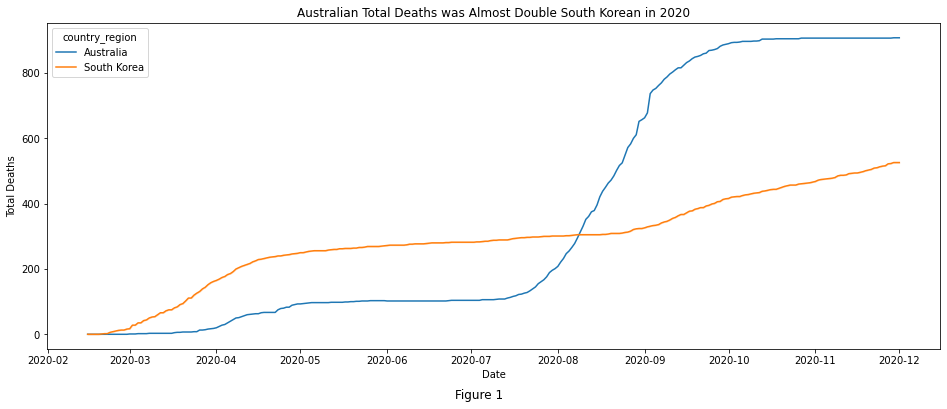

In [75]:
plt.figure(figsize=(16, 6))

sns.lineplot(x="date", y="total_deaths", hue="country_region", data= df.toPandas())
plt.title('Australian Total Deaths was Almost Double South Korean in 2020')
plt.xlabel('Date')
plt.ylabel('Total Deaths')
txt="Figure 1"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

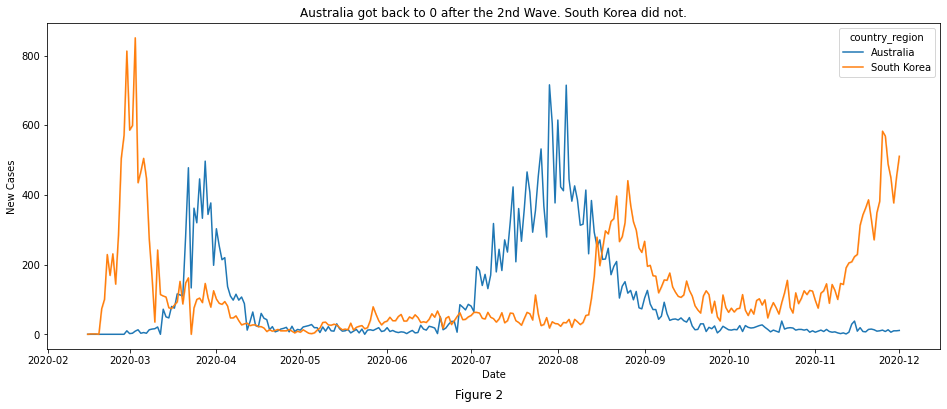

In [74]:
plt.figure(figsize=(16, 6))

sns.lineplot(x="date", y="new_cases", hue="country_region", data= df.toPandas())
plt.title('Australia got back to 0 after the 2nd Wave. South Korea did not.')
plt.xlabel('Date')
plt.ylabel('New Cases')
txt="Figure 2"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

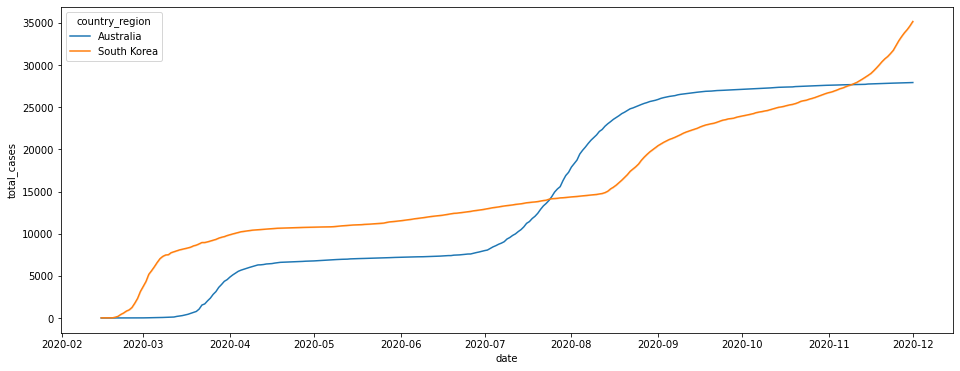

In [32]:
sns.lineplot(x="date", y="total_cases", hue="country_region", data= df.toPandas())
plt.show()

In [34]:
df.columns

['country_region',
 'date',
 'retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'parks_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'residential_percent_change_from_baseline',
 'iso_code',
 'continent',
 'location',
 'total_cases',
 'new_cases',
 'new_cases_smoothed',
 'total_deaths',
 'new_deaths',
 'new_deaths_smoothed',
 'total_cases_per_million',
 'new_cases_per_million',
 'new_cases_smoothed_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'new_deaths_smoothed_per_million',
 'reproduction_rate',
 'icu_patients',
 'icu_patients_per_million',
 'hosp_patients',
 'hosp_patients_per_million',
 'weekly_icu_admissions',
 'weekly_icu_admissions_per_million',
 'weekly_hosp_admissions',
 'weekly_hosp_admissions_per_million',
 'total_tests',
 'new_tests',
 'total_tests_per_thousand',
 'new_tests_per_thousand',
 'new_tests_smoothed',


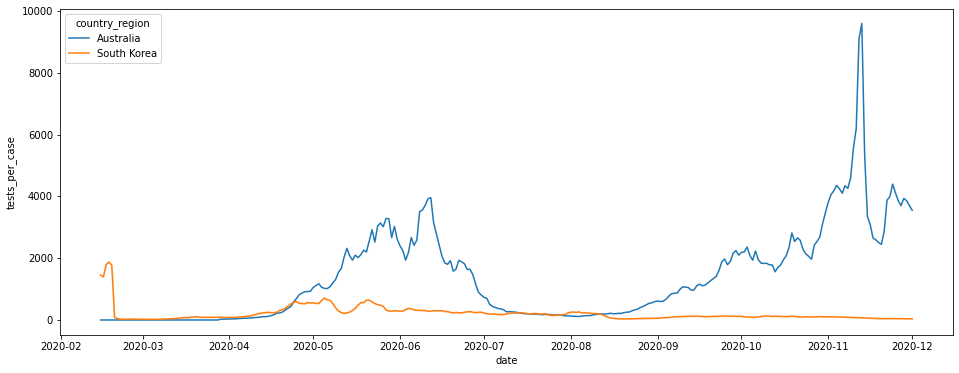

In [35]:
sns.lineplot(x="date", y="tests_per_case", hue="country_region", data= df.toPandas())
plt.show()

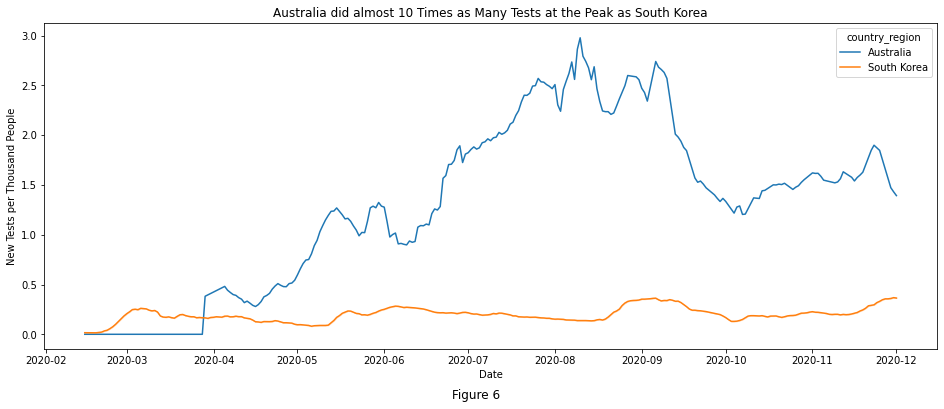

In [72]:
plt.figure(figsize=(16, 6))
sns.lineplot(x="date", y="new_tests_smoothed_per_thousand", hue="country_region", data= df.toPandas())
plt.title('Australia did almost 10 Times as Many Tests at the Peak as South Korea')
plt.xlabel('Date')
plt.ylabel('New Tests per Thousand People')
txt="Figure 6"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

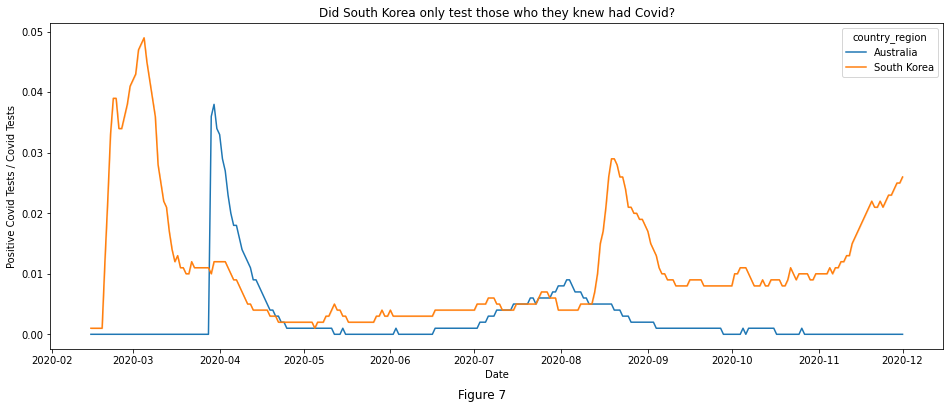

In [73]:
plt.figure(figsize=(16, 6))
sns.lineplot(x="date", y="positive_rate", hue="country_region", data= df.toPandas())
plt.title('Did South Korea only test those who they knew had Covid?')
plt.xlabel('Date')
plt.ylabel('Positive Covid Tests / Covid Tests')
txt="Figure 7"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

Korea had a much bigger positive rate and a lower testing rate. Maybe lots of covid cases were missed.

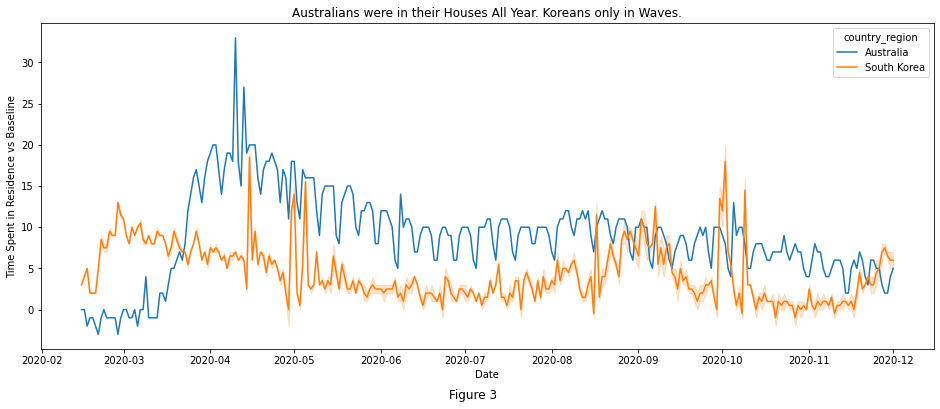

In [63]:
plt.figure(figsize=(16, 6))
sns.lineplot(x="date", y="residential_percent_change_from_baseline", hue="country_region", data= df.toPandas())
plt.title('Australians were in their Houses All Year. Koreans only in Waves.')
plt.xlabel('Date')
plt.ylabel('Time Spent in Residence vs Baseline')
txt="Figure 3"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

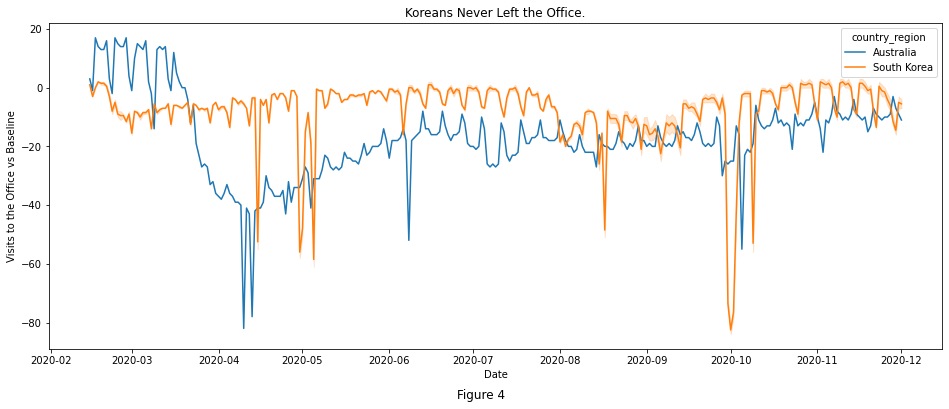

In [65]:
plt.figure(figsize=(16, 6))
sns.lineplot(x="date", y="workplaces_percent_change_from_baseline", hue="country_region", data= df.toPandas())
plt.title('Koreans Never Left the Office.')
plt.xlabel('Date')
plt.ylabel('Visits to the Office vs Baseline')
txt="Figure 4"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

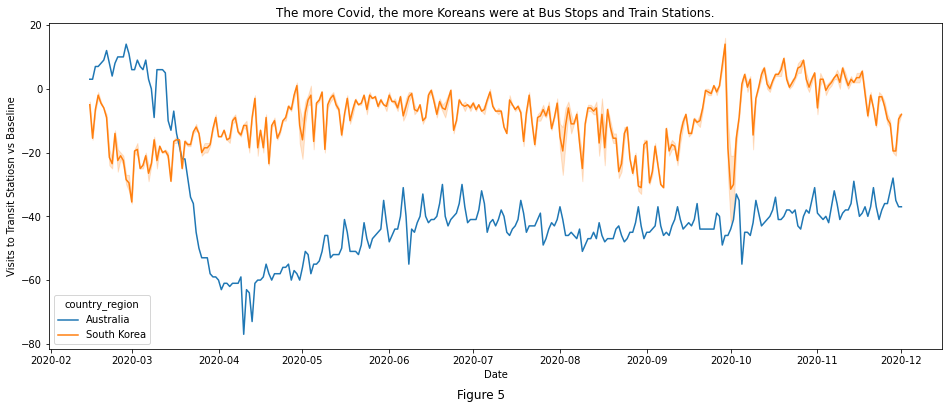

In [67]:
plt.figure(figsize=(16, 6))
sns.lineplot(x="date", y="transit_stations_percent_change_from_baseline", hue="country_region", data= df.toPandas())
plt.title('The more Covid, the more Koreans were at Bus Stops and Train Stations.')
plt.xlabel('Date')
plt.ylabel('Visits to Transit Statiosn vs Baseline')
txt="Figure 5"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

Seems like Australia had a bigger reduction in movement, while South Korea only reduced movement during big peaks. Soon after peaks, movement increased again, especially in transit centers, which returned to normal soon after their second wave. It is possible that transit center movement was why South Korea never completly got rid of Covid.

 'icu_patients',
 'icu_patients_per_million',
 'hosp_patients',
 'hosp_patients_per_million',
 'weekly_icu_admissions',
 'weekly_icu_admissions_per_million',
 'weekly_hosp_admissions',
 'weekly_hosp_admissions_per_million', 

 Apparently all 0

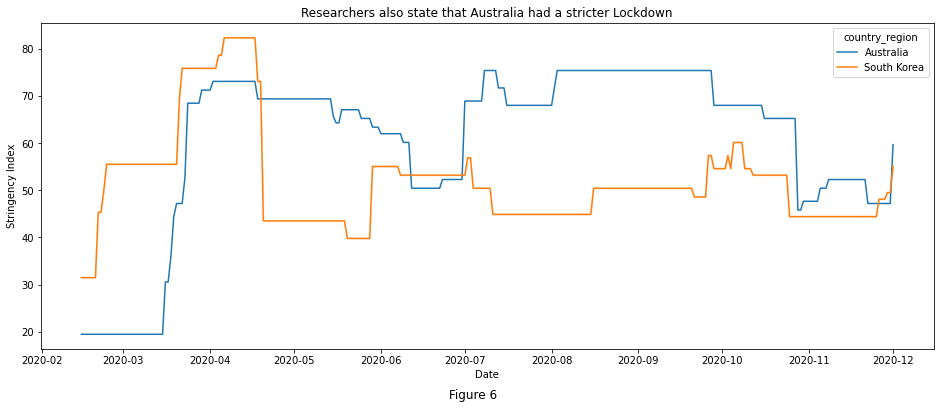

In [68]:
plt.figure(figsize=(16, 6))
sns.lineplot(x="date", y="stringency_index", hue="country_region", data= df.toPandas())
plt.title('Researchers also state that Australia had a stricter Lockdown')
plt.xlabel('Date')
plt.ylabel('Stringency Index')
txt="Figure 6"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

What I want here is South Korea / Australia for following variables
 'population',
 'population_density',
 'median_age',
 'aged_65_older',
 'aged_70_older',
 'gdp_per_capita',
 'extreme_poverty',
 'cardiovasc_death_rate',
 'diabetes_prevalence',
 'female_smokers',
 'male_smokers',
 'handwashing_facilities',
 'hospital_beds_per_thousand',
 'life_expectancy',
 'human_development_index'

In [42]:
df_single_row_aus = spark.sql("""
SELECT population AS aus_pop, median_age AS aus_med_age,  aged_70_older AS aus_oldies,
gdp_per_capita AS aus_gdp, extreme_poverty AS aus_pov, 
cardiovasc_death_rate AS aus_cardiovasc, diabetes_prevalence AS aus_diabates ,
 female_smokers AS aus_fsmokers, male_smokers AS aus_msmokers, 
hospital_beds_per_thousand  AS aus_hop_bed_1000, life_expectancy  AS aus_life_exp, human_development_index AS aus_hdi
FROM temp_cases 
WHERE location == 'Australia'
LIMIT 1
""")
df_single_row_kor = spark.sql("""
SELECT 'a' AS A, population AS kor_pop, median_age AS kor_med_age,  aged_70_older AS kor_oldies,
gdp_per_capita AS kor_gdp, extreme_poverty AS kor_pov, 
cardiovasc_death_rate AS kor_cardiovasc, diabetes_prevalence AS kor_diabates ,
 female_smokers AS kor_fsmokers, male_smokers AS kor_msmokers, 
hospital_beds_per_thousand  AS kor_hop_bed_1000, life_expectancy  AS kor_life_exp, human_development_index AS kor_hdi
FROM temp_cases 
WHERE location == 'South Korea'
LIMIT 1
""")

In [43]:
def to_long_aus(df, by):

    # Filter dtypes and split into column names and type description
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes if c not in by))
    # Spark SQL supports only homogeneous columns
    assert len(set(dtypes)) == 1, "All columns have to be of the same type"

    # Create and explode an array of (column_name, column_value) structs
    kvs = explode(array([
      struct(lit(c).alias("key"), col(c).alias("val_aus")) for c in cols
    ])).alias("kvs")

    return df.select(by + [kvs]).select(by + ["kvs.key", "kvs.val_aus"])

def to_long_kor(df, by):

    # Filter dtypes and split into column names and type description
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes if c not in by))
    # Spark SQL supports only homogeneous columns
    assert len(set(dtypes)) == 1, "All columns have to be of the same type"

    # Create and explode an array of (column_name, column_value) structs
    kvs = explode(array([
      struct(lit(c).alias("key"), col(c).alias("val_kor")) for c in cols
    ])).alias("kvs")

    return df.select(by + [kvs]).select(by + ["kvs.key", "kvs.val_kor"])

In [44]:
df_aus = spark.sql("""
SELECT location, population, median_age,  aged_65_older, aged_70_older,
gdp_per_capita, extreme_poverty, 
cardiovasc_death_rate, diabetes_prevalence,
 female_smokers, male_smokers, 
hospital_beds_per_thousand, life_expectancy, human_development_index
FROM temp_cases 
WHERE location == 'Australia'
LIMIT 1
""")
df_aus = to_long_aus(df_aus, ["location"])

In [45]:
df_kor = spark.sql("""
SELECT location, population, median_age,  aged_65_older, aged_70_older,
gdp_per_capita, extreme_poverty, 
cardiovasc_death_rate, diabetes_prevalence,
 female_smokers, male_smokers, 
hospital_beds_per_thousand, life_expectancy, human_development_index
FROM temp_cases 
WHERE location == 'South Korea'
LIMIT 1
""")
df_kor = to_long_kor(df_kor, ["location"])

In [46]:
bar_chart_data = df_aus.join(df_kor, on = "key").\
    withColumn("kor_div_by_aus", (F.col("val_kor") / F.col("val_aus"))).\
    orderBy('kor_div_by_aus',ascending=False)
bar_chart_data = bar_chart_data.select("*", initcap(col('key'))).toPandas()

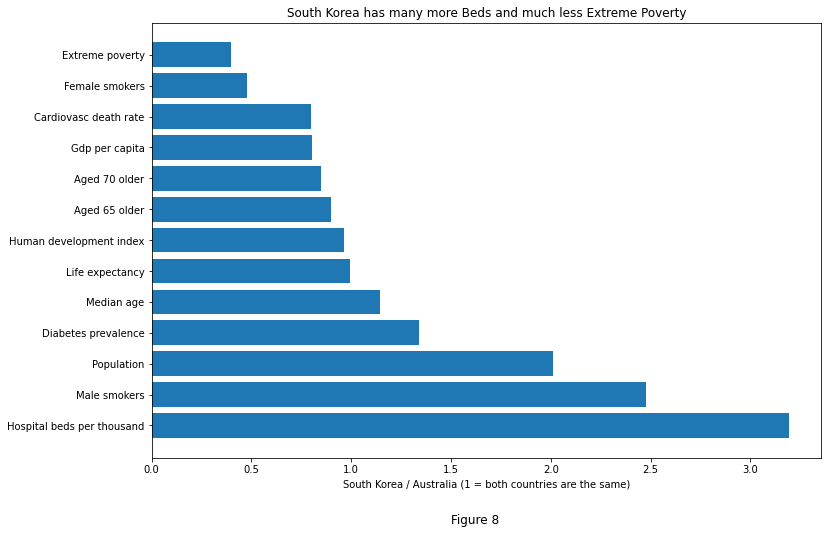

In [71]:
plt.barh(bar_chart_data['initcap(key)'].str.replace('_',' '),bar_chart_data['kor_div_by_aus'])
plt.title('South Korea has many more Beds and much less Extreme Poverty')
plt.xlabel('South Korea / Australia (1 = both countries are the same)')

txt="Figure 8"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.show()